## object detection

- 영상처리에서 가장 중요
- 딥러닝통해서 가장 많은 성능 향상을 이룸
-  사람만큼 빠르고 정확함

주된 이미지?
- 가장 큰 부분을 차지하고 중앙에 위치


1. classification
2. object detection
    - classification + localization
    - 사각형 영역에 무엇이 어디에 있는지
    - multiple, single object
3. Segmentation
    - 점 단위로 영역 찾음
    - smantic
        - 같은 클래스는 하나로 간주
    - instance segmentation
        - 인스턴스별로 구분
  
### Convolution Neural Network
- 2 stage 찾고 분류    
    - 높은 **정확도**
    - Faster R-CNN
- 1 stage 동시에 찾으면서 분류
    - 빠른 **속도**
    - YOLO
    
### R-CNN    
#### Rich Feature Hierarchies for Accurate Object Detection and Semantic Segmentation

### SPP-net
#### Convolutional Neural Networks for Visual Recognition


---

## Data Augmentation

> - overfitting 막는 법
    - dropout
    - early stopping
    - **data augmentation**
    - regularizer


1. Augmentor 
    - 외부 라이브러리 이용해서 쉽게 사용하도록 도와줌
    - 확장 어려움
2. 사용자 지정
    1. Preprocessing layer
    2. Lambda layer
    3. tf.image  

참고 : https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko

#### TensorFlow Dataset
데이터 세트 다운로드
- TensorFlow Dataset 이용
    - 지도학습용 데이터셋
    - 3-way hold-out: train, test, validation
    - 관련 메타데이터 제공
    
    
**변환**
- numpy -> tf.data.Dataset
    - 변환에는 문제 없음
    - 변환 리소스 문제
- tensorflow_io 직접불러오기 


**좌우반전**
- PIL, OpenCV 이용
- 따로 저장하지 않음

In [72]:
import tensorflow as tf

import tensorflow_datasets as tfds

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

tf.data.Dataset.from_tensors([1,2,3]) #tf.data.Dataset으로 바꿔줌

# tf.data.Dataset.from_tensor_slices #batch 기반으로 나눔

<TensorDataset shapes: (3,), types: tf.int32>

In [33]:
issubclass(train_ds.__class__, tf.data.Dataset ) #상속받음

True

In [73]:
train_ds.batch(512)

<BatchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.uint8, tf.int64)>

In [8]:
metadata.features  #FeaturesDict : Dictionary 상속받음

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

In [61]:
metadata.features['label'].int2str(1)  
# Labelencoder의 inverse_transform 

'daisy'

### 1. preprocessing layers
- 모델 내, 밖서 레이어 적용 가능

    - resizing :이미지 크기 맞추기
    - rescaling: 스케일링
      - [0,1] 표준화
    - RandomFlip 랜덤 상하좌우반전
    - RandomRotation 랜덤 회전
    
    
tf.keras.layers.experimental.preprocessing #이미지,텍스트 전처리 기능 제공

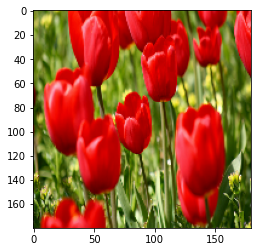

In [74]:
from tensorflow.keras import layers

IMG_SIZE = 180

image, label = next(iter(train_ds))
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

import matplotlib.pyplot as plt
result = resize_and_rescale(image)
_ = plt.imshow(result)

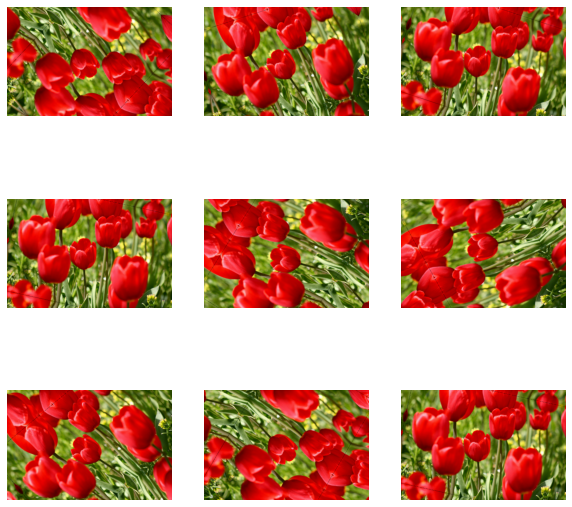

In [75]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
image = tf.expand_dims(image, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)#함수형 패러다임처럼 사용
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off") #함수형 패러다임처럼 사용


1) 모델 내 적용

In [ ]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

2) 모델 밖 적용

In [76]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(2,)
])

In [18]:
model.built
# 모델 생성 직후에는 내부적으로 build되어있지 않음
# input_shape 없어도 됨

False

In [19]:
model.predict([1,2,3,]) #내부에서 build
model.built

True

build
- 행렬연산 input,output shape알면 내부 알아서 자동 조정 가능 

compile
- 학습 전략
    - loss
    - optimizer
    - metrics 
    
### @tf.function
- layer grouping 통해서 그룹별 매소드 지원 가능
- 하나의 레이어 처럼 취급해서 관리 쉬움
- 모델안에 모델을 넣을 수 있음
    - transfer learning에 활용

In [81]:

num_classes = metadata.features['label'].num_classes


#모델내부에서 Flatten

model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=5

history = model.fit(
  aug_ds.batch(512),
  validation_data=val_ds.batch(512),
  epochs=epochs
)

### 2. layers.Lambda 레이어
- 재활용하지 않기 위해서 일회용으로 사용
- 함수(지정한 규칙)를 사용해서 많은 값을 한꺼번에 바꾸어줌

전처리에서는 사람의 개입이 필요함

> - feature selection
        1. filter
            - 통계
        2. **embeded**
            - 학습을 통해서 전처리함
        3. wrapper
        
모든 것이 함수형 패러다임
- layer도 함수처럼 사용 (layer ==function== array)

In [39]:
#1.Lambda 함수
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

색상 반전을 한 이유
- 색상에대한 영향을 줄이기 위해서 반전함
-  convolution 특징  단순학 색상, 점,선 부터 추출 (eg.Alex-net)

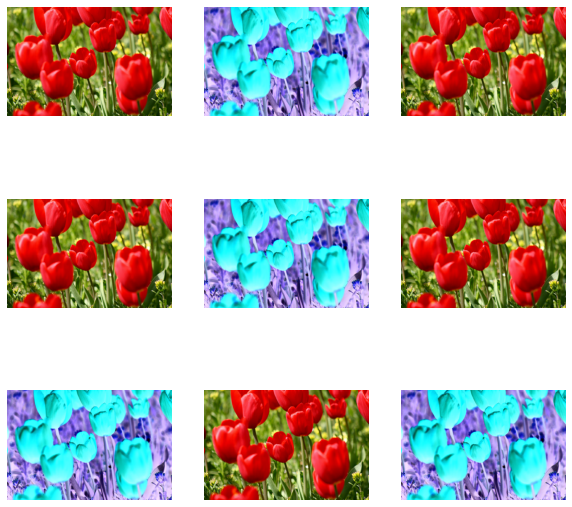

In [82]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image) 
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

재활용 하고 싶은 경우
- `()()` closure technique : __init__, call 

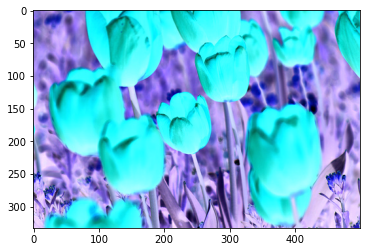

In [83]:
#2. Lambda subclassing
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

_ = plt.imshow(RandomInvert(factor=0.5)(image)[0])

call함수
- built 여부 확인
- super().call

**tf.keras.models.Sequential.__base__**

- _run_internal_graph 부름
- 계속 위임함
- build check, __call__
    - 커스텀 레이터 참고 : https://www.tensorflow.org/tutorials/customization/custom_layers?hl=ko
    

---

### 3. tf.image
- 텐서에서 자주 사용하는 기능 만들어 둠
  - tf.image.flip_left_right() 좌우반전
  - tf.image.rgb_to_grayscale() 흑백
    -     - 색상 정보를 제거하여 계산량 줄임
  - tf.image.adjust_saturation()채도 조정
  - tf.image.adjust_brightness) 밝기 조정
  - tf.image.central_crop(, central_fraction) 중앙에 맞춰 자르기
  - tf.image.rot90() 90도 회전
  
  
- 전체를 메모리에 올리지 않아서 indexing, slicing 불가
- iter, for ... break 사용

In [35]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)
image, label = next(iter(train_ds))

In [ ]:
# tf.image.flip_left_right(image)
# tf.image.rgb_to_grayscale(image)
# tf.image.adjust_saturation(image, 3)
# tf.image.random_brightness
# tf.image.adjust_brightness(image, 0.4)
# tf.image.random_crop
# tf.image.central_crop(image, central_fraction=0.5)
# tf.image.rot90(image)
# tf.image.resize
# tf.image.resize_with_crop_or_pad

In [36]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32) 
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

def augment(image,label):
    ''' 데이터 증강 '''
    image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [37]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.shuffle(1000).map(augment, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [38]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 38s 418ms/step - loss: 1.4665 - accuracy: 0.3587 - val_loss: 1.2222 - val_accuracy: 0.5041
Epoch 2/5
92/92 [==============================] - 39s 422ms/step - loss: 1.1788 - accuracy: 0.5126 - val_loss: 1.1080 - val_accuracy: 0.5531
Epoch 3/5
92/92 [==============================] - 44s 480ms/step - loss: 1.0441 - accuracy: 0.5858 - val_loss: 0.9165 - val_accuracy: 0.6621
Epoch 4/5
92/92 [==============================] - 39s 420ms/step - loss: 0.9552 - accuracy: 0.6277 - val_loss: 0.9295 - val_accuracy: 0.6376
Epoch 5/5
92/92 [==============================] - 43s 470ms/step - loss: 0.8453 - accuracy: 0.6717 - val_loss: 0.8734 - val_accuracy: 0.6730
